In [123]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
from multitest import MultiTest
import pandas as pd

from src.DetectLM import DetectLM
from src.fit_survival_function import fit_per_length_survival_function

2128


<Axes: xlabel='name'>

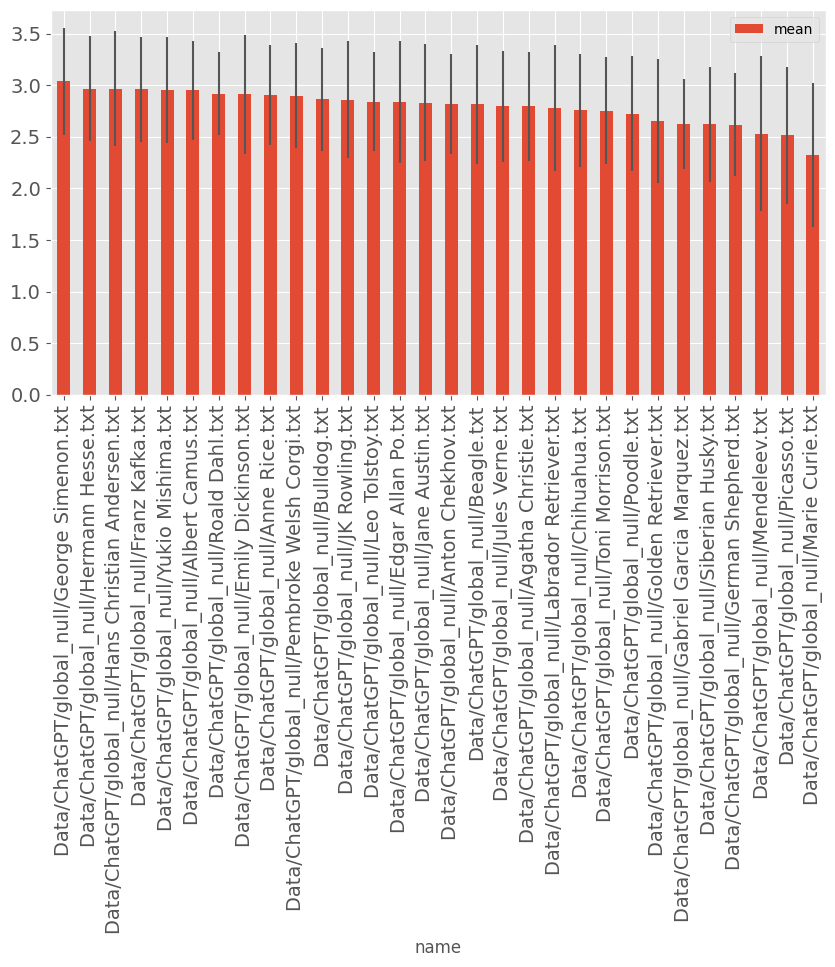

In [146]:
# check null values of realistic edits
df1 = pd.read_csv("results/phi-2_no_context_files_machine.csv")
print(len(df1))
df1.groupby('name').response.agg(['mean', 'std']).sort_values('mean', ascending=False).plot(kind='bar', y='mean', yerr='std', figsize=(10, 5), fontsize=14)


In [149]:
df1[~df1.name.str.contains('Curie')].to_csv("results/phi-2_no_context_files_machine.csv", index=False)

In [145]:
dfm = df1.set_index('name').join(df2.set_index('name'), lsuffix='_1', rsuffix='_2')

dfm[dfm.isna().any(axis=1)].index.unique()

Index(['Data/ChatGPT/global_null/Emily Dickinson.txt',
       'Data/ChatGPT/global_null/Gabriel Garcia Marquez.txt',
       'Data/ChatGPT/global_null/Hans Christian Andersen.txt',
       'Data/ChatGPT/global_null/Jules Verne.txt',
       'Data/ChatGPT/global_null/Leo Tolstoy.txt'],
      dtype='object', name='name')

2024


<Axes: xlabel='name'>

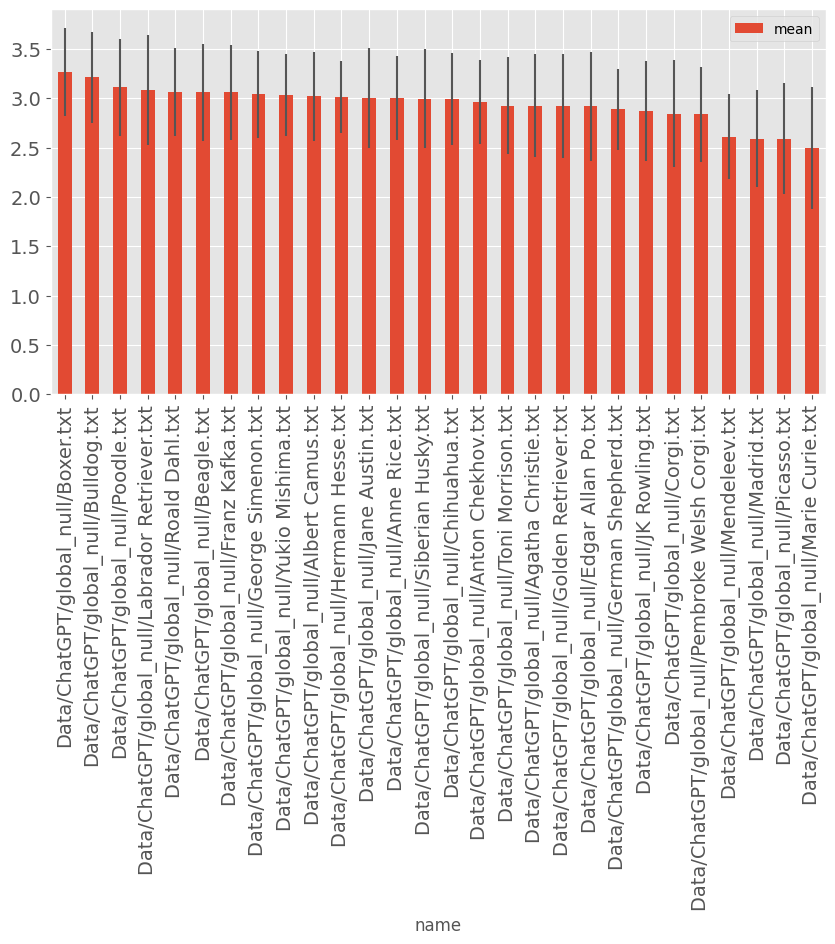

In [127]:
# check null values of realistic edits
df2 = pd.read_csv("results/gpt2-xl_no_context_files_machine_truncated.csv")
print(len(df2))
df2.groupby('name').response.agg(['mean', 'std']).sort_values('mean', ascending=False).plot(kind='bar', y='mean', yerr='std', figsize=(10, 5), fontsize=14)


In [55]:
from src.HC_survival_function import get_HC_survival_function
HC_pval_func = get_HC_survival_function(HC_null_sim_file="HC_null_sim_results.csv")

INFO:root:Loading HC null values from HC_null_sim_results.csv...


In [14]:
import re
import os
# get base filename without extension:
input_file = "Data/Bio/mixed/Toni Morrison_edited.txt"
name = os.path.basename(input_file)
print(name)
search_name = re.findall(r"([A-Za-z ]+)(?:mix| mix| edited.+|_edited.+|)?(?:.txt|.csv)?", name)
search_name

Toni Morrison_edited.txt


['Toni Morrison']

In [8]:
!pip3 install sklearn

In [52]:
from text_detect import get_survival_function
from transformers import AutoTokenizer, AutoModelForCausalLM    
from src.PerplexityEvaluator import PerplexityEvaluator
from src.DetectLM import DetectLM
from src.PrepareSentenceContext import PrepareSentenceContext
import pandas as pd
import pickle

INPUT_FILE = 'example_text.txt'

# Load the logloss p-value function. Ususally one must fit this function using triaining data
# from the null class and ``fit_survival_function``.
# Here we load a pre-fitted function for the GPT-2 language model under Wikipedia-Introduction 
# dataset and no context.
with open('example/logloss_pval_function.pkl', 'rb') as f:
    pval_function = pickle.load(f)

# Initialize PerplexityEvaluator with a language model and a tokenizer
lm_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(lm_name)

sentence_detector = PerplexityEvaluator(AutoModelForCausalLM.from_pretrained(lm_name),
                    AutoTokenizer.from_pretrained(lm_name))

# initialize the detector...
detector = DetectLM(sentence_detector, pval_function,
                    min_len=8, max_len=50, length_limit_policy='truncate')

# parse text from an input file 
with open(INPUT_FILE, 'rt') as f:
    text = f.read()
parse_chunks = PrepareSentenceContext(context_policy=None)
chunks = parse_chunks(text)

# Test document
res = detector(chunks['text'], chunks['context'])
print(res)

8it [00:00, 27.83it/s]

{'sentences':                                             sentence  response    pvalue  \
0                                    Example text.\n  6.100810       NaN   
1  The text below explains the default configurat...  4.303938       NaN   
2  Some of the configurations can be easily adjus...  3.539569  0.571496   
3  The most important parameter is the path to th...  4.495553  0.064241   
4              The default sentence parser is spacy.  7.019018       NaN   
5  This parser somtimes has unexpected behavior, ...  5.509454  0.010378   
6  There is also an instruction to ignore sentenc...  4.451342  0.116835   
7  Additionally, sentences that are too long are ...  3.315172  0.794605   

  context                         comment   mask  
0    None  ignored (below minimal length)  False  
1    None  ignored (below minimal length)  False  
2    None                              OK  False  
3    None                              OK   True  
4    None  ignored (below minimal length)  Fal

In [69]:
from scipy.interpolate import RectBivariateSpline
import numpy as np
ll = np.arange(5, 500)
xx0 = np.arange(0.1, 10, 0.01)

ll_valid = []
zz = []
for l in ll:
    ll_valid.append(l)
    zz.append(HC_pval_func(l, xx0)[0])

func = RectBivariateSpline(ll_valid, xx0, np.vstack(zz))

In [74]:
func(100, 0.5)

array([[0.77396079]])

In [84]:
num_valid = res['sentences']['pvalue'].dropna().shape[0]
func(num_valid ,res['HC'])

array([[0.1065159]])

In [87]:
print("Salaries: ", 18000/37500)
print("Equipment: ", 2500/37500)
print("Supplies: ", 2500/37500)
print("Travel: ", 7500/37500)
print("Other Expenses: ", 3500/37500)


Salaries:  0.48
Equipment:  0.06666666666666667
Supplies:  0.06666666666666667
Travel:  0.2
Other Expenses:  0.09333333333333334


In [80]:
num_valid

8

In [76]:
import pickle
with open("example/HC_pval_function.pkl", "wb") as f:
    pickle.dump(func, f)

In [17]:
import pickle as pkl
with open('example/example_pval_function.pkl', 'wb') as f:
    pkl.dump(pval_function, f)


AttributeError: Can't pickle local object 'fit_per_length_survival_function.<locals>.func2d'

### Analyze results

In [230]:
df = pd.read_csv('results/synthetic_data_HV_vals.csv')

In [180]:
res = []
for c in df.groupby(['dataset_name', 'min_length', 'itr']):
    #print(c[0])
    HC_null = c[1].loc[c[1]['epsilon'] == 0.0, 'HC'].values
    eps_vals = df['epsilon'].unique()
    for eps_val in eps_vals:
        if eps_val > 0:
            HC_alt = c[1].loc[c[1]['epsilon'] == eps_val, 'HC'].values
            tt = np.linspace(HC_null.min(), HC_null.max(), 1000)
            P1 = np.mean(np.expand_dims(HC_alt, 1) > np.expand_dims(tt, 0), 0)
            P2 = np.mean(np.expand_dims(HC_null, 1) <= np.expand_dims(tt, 0), 0)
            #print(f"eps = {eps_val}, acc_t = {np.max(P1 + P2)/ 2}")
            res.append({'dataset_name': c[0][0] ,'min_length': c[0][1],'itr': c[0][2], 'epsilon': eps_val, 'acc_t': np.max(P1 + P2)/ 2})

/Users/kipnisal/Dropbox/Research/AuthorshipAI/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kipnisal/Dropbox/Research/AuthorshipAI/env/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [245]:
df = pd.read_csv('/Users/kipnisal/Dropbox/Research/AuthorshipAI/results/synthetic_data_report_al_02_nMonte_30.csv')
df.groupby(['model', 'epsilon', 'min_length', 'dataset']).accuracy.agg(['mean', 'std']).round(2)

mean   std
model   epsilon min_length dataset              
gpt2-xl 0.0     50         abstracts  0.53  0.01
                           news       0.55  0.00
                           wiki-long  0.53  0.01
                100        abstracts  0.54  0.01
                           news       0.56  0.01
                           wiki-long  0.54  0.01
                200        abstracts  0.54  0.01
                           news       0.56  0.01
                           wiki-long  0.54  0.01
        0.1     50         abstracts  0.64  0.01
                           news       0.61  0.01
                           wiki-long  0.64  0.01
                100        abstracts  0.69  0.02
                           news       0.65  0.01
                           wiki-long  0.69  0.02
                200        abstracts  0.76  0.02
                           news       0.71  0.01
                           wiki-long  0.76  0.01
        0.2     50         abstracts  0.76  0.01
                           news       0.69  0.01
                           wiki-long  0.77  0.01
                100        abstracts  0.84  0.01
                           news       0.76  0.01
                           wiki-long  0.84  0.01
                200        abstracts  0.92  0.01
                           news       0.83  0.01
                           wiki-long  0.91  0.01

In [243]:
df.itr

0       0
1       0
2       0
3       0
4       0
       ..
797    29
798    29
799    29
800    29
801    29
Name: itr, Length: 802, dtype: int64

In [173]:
file_name = 'results/synthetic_data_report_al_20.csv'
#file_name = 'results/synthetic_data_report_al_0005.csv'
df = pd.read_csv(file_name)
level = df[df['epsilon'] == 0.0].groupby('dataset')['detection_rate'].mean()
df =df.join(level, rsuffix='_null_mean', on='dataset')
df['accuracy'] = (1 - df['detection_rate_null_mean'] + df['detection_rate'])/2

df.groupby(['epsilon','min_length', 'dataset']).accuracy.agg(['mean','std'])

mean       std
epsilon min_length dataset                      
0.0     50         abstracts  0.498384  0.008711
                   news       0.497092  0.002872
                   wiki-long  0.500461  0.003835
        100        abstracts  0.495488  0.007389
                   news       0.501517  0.005121
                   wiki-long  0.499231  0.005802
        200        abstracts  0.506128  0.007490
                   news       0.501390  0.006689
                   wiki-long  0.500308  0.009654
0.1     50         abstracts  0.604824  0.009592
                   news       0.605097  0.003604
                   wiki-long  0.665572  0.009670
        100        abstracts  0.651330  0.006500
                   news       0.653058  0.003968
                   wiki-long  0.728858  0.009104
        200        abstracts  0.715613  0.012200
                   news       0.720330  0.006553
                   wiki-long  0.795399  0.008432
0.2     50         abstracts  0.663256  0.006339
                   news       0.673669  0.001574
                   wiki-long  0.755686  0.007854
        100        abstracts  0.723477  0.007312
                   news       0.737004  0.004618
                   wiki-long  0.821285  0.005793
        200        abstracts  0.783648  0.006381
                   news       0.810574  0.005284
                   wiki-long  0.863814  0.005231

### Develop Testing Process

In [4]:
dataset_name = 'wiki-bio'
model_name = "gpt2-xl"

params = {}
params['ignore-first-sentence'] = True
params['null-data-file'] = f"results/{model_name}_no_context_{dataset_name}_machine.csv"
params['language-model-name'] = model_name
params['number-of-interpolation-points'] = 47
params['max-tokens-per-sentence'] = 50
params['min-tokens-per-sentence'] = 8
params['hc-type'] = "stbl"

In [5]:
def get_null_data(params):
    df_null = pd.read_csv(params['null-data-file'])
    if params['ignore-first-sentence']: 
        df_null = df_null[df_null.num > 1]
    return df_null

def get_survival_function(df, G=101):
    """
    One survival function for every sentence length in tokens

    Args:
    :df:  data frame with columns 'response' and 'length'

    Return:
        bivariate function (length, responce) -> (0,1)

    """
    assert not df.empty
    value_name = "response" if "response" in df.columns else "logloss"

    df1 = df[~df[value_name].isna()]
    ll = df1['length']
    xx1 = df1[value_name]
    return fit_per_length_survival_function(ll, xx1, log_space=True, G=G)

       
df_null = get_null_data(params)
pval_functions = get_survival_function(df_null, G=params['number-of-interpolation-points'])

FileNotFoundError: [Errno 2] No such file or directory: 'results/gpt2-xl_no_context_wiki-bio_machine.csv'

In [288]:
ds_machine = pd.read_csv(f"results/{model_name}_no_context_{dataset_name}_machine.csv")
ds_human = pd.read_csv(f"results/{model_name}_no_context_{dataset_name}_human.csv")

117746
361391


In [291]:
eps = 0.1

ds_merged = ds_machine.merge(ds_human, on='name', how='inner')

joint_names = ds_merged['name'].tolist()


ds_pool = ds_human[ds_human['name'].isin(joint_names)]
ds_sample = ds_pool.groupby("name").sample(frac=eps)

print(len(ds_sample))

ds_sample['human'] = True
ds_machine['human'] = False
ds_mixed = pd.concat([ds_machine[ds_machine['name'].isin(joint_names)], ds_sample])

print(ds_mixed.groupby('name')['human'].mean().mean())

9780
0.07752279215394678


In [262]:
def group_articles_to_minimum_length(df, min_length):
    """
    Rearrange group names so that every group has at least
    :min_length: elements
    """
    df_grouped = df.copy()
    df_grouped.loc[:, 'new_name'] = df['name'].copy()
    groups = list(ds_mixed.groupby('name'))
    lo_names = []
    while len(groups) > 0:
        c = groups.pop(0)
        acc = len(c[1])
        while (acc <= min_length) and len(groups)>0:
            c1 = groups.pop(0)
            acc += len(c1[1])
            df_grouped.loc[df['name'] == c1[0], 'new_name'] = c[0]

    return df_grouped

min_length = 100
ds_mixed_grouped = group_articles_to_minimum_length(ds_mixed, min_length)


In [263]:
detectlm = DetectLM(lambda x: 0,
                    pval_functions,
                     min_len=params['min-tokens-per-sentence'],
                    max_len=params['max-tokens-per-sentence'],
                    HC_type=params['hc-type'],
                    ignore_first_sentence=params['ignore-first-sentence']
                      )
stbl = True if params['hc-type']=='stbl' else False

min_no_sentences = 10

results = []
too_short = []
for c in tqdm(ds_mixed_grouped.groupby('new_name')):
    responses = c[1]['response']
    lengths = c[1]['length']
    if len(responses) > min_no_sentences:
      pvals, comments = detectlm._get_pvals(responses, lengths)
      pvals = np.vstack(pvals).squeeze()
      mt = MultiTest(pvals, stbl=stbl)
      hc = mt.hc()[0]
      results.append(dict(id=c[0], HC=hc))
    else:
       too_short.append(c)

100%|██████████| 3304/3304 [00:01<00:00, 2527.09it/s]


In [264]:
crit_vals = pd.read_csv("HC_critvals.csv")

In [265]:
sig_level = 0.05
t0 = crit_vals[(crit_vals.n == min_length) & (crit_vals.alpha == sig_level)].q_alpha.values[0]
acc = np.mean(pd.DataFrame.from_dict(results)['HC'] > t0)

print(f"Model={model_name}, dataset={dataset_name}, epsilon={eps}, length={min_length}, sig_level={sig_level} --> detection rate {acc}")

Model=gpt2-xl, dataset=news, epsilon=0.1, length=100, sig_level=0.05 --> detection rate 0.3662227602905569
